# Topic - Sentiment Distribution and Extremes Analysis

This notebook accomplishes the following tasks:
1. perform LDA theme modeling on tweets
2. Analyze the sentiment distribution under each topic
3. Identify extreme sentiment topics
4. Visualize the analysis results

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')


## 2. LDA theme modeling

In [2]:
import pandas as pd

df = pd.read_csv("../2_data/tweet_level_sentiment.csv")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# add financial-specific stop words
financial_stop_words = {'stock', 'market', 'price', 'trading', 'trade', 'investor', 'investment', 
                       'nvda', 'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 
                       'bearish', 'chart', 'technical', 'analysis', 'fundamental', 'earnings', 
                       'quarter', 'report', 'financial', 'company', 'firm', 'business'}
stop_words.update(financial_stop_words)

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df['processed_text'] = df['Processed_Tweet'].apply(preprocess_text)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

n_topics = 8  
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=0
)

topic_distribution = lda.fit_transform(X)
df['topic'] = topic_distribution.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print("Keywords for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


    topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)
topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]
print(topic_sentiment_stats)

df.to_csv("../2_data/tweets_with_LDAtopics.csv", index=False)


[nltk_data] Downloading package punkt to /Users/q/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for each topic:
Topic 1: compani, amp, chip, arm, lower, said, game, sinc, better, like
Topic 2: today, day, tomorrow, like, close, week, look, let, bull, green
Topic 3: time, short, long, dip, high, year, got, make, fuck, like
Topic 4: tsla, good, great, look, strong, gap, support, start, stay, alway
Topic 5: spi, aapl, amd, qqq, bought, amzn, msft, posit, lol, split
Topic 6: earn, rocket, watch, hour, new, hope, bad, news, everi, data
Topic 7: amd, intc, anoth, load, tri, continu, rip, work, semi, miss
Topic 8: come, big, money, drop, want, wait, nice, soon, run, bounc
       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 35352         0.0564              0.5026 -1.0  1.0   
1                 58716         0.0862              0.6124 -1.0  1.0   
2                 34186        -0.0253              0.6940 -1.0  1.0   
3                 24568         0.1895              0


## 3. Theme-sentiment distribution analysis

       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 42442         0.0281              0.3536 -1.0  1.0   
1                 40138         0.0518              0.4415 -1.0  1.0   
2                 21729         0.0192              0.4196 -1.0  1.0   
3                 40388         0.0324              0.4951 -1.0  1.0   
4                 37760        -0.0248              0.4495 -1.0  1.0   
5                 34921         0.0265              0.4124 -1.0  1.0   
6                 23186        -0.0336              0.4152 -1.0  1.0   
7                 26082         0.1690              0.4893 -1.0  1.0   

       High positive ratio  High negative ratio  
topic                                            
0                   0.0770               0.0489  
1                   0.1247               0.0729  
2                   0.0978               0.0786  
3                   0.1393   

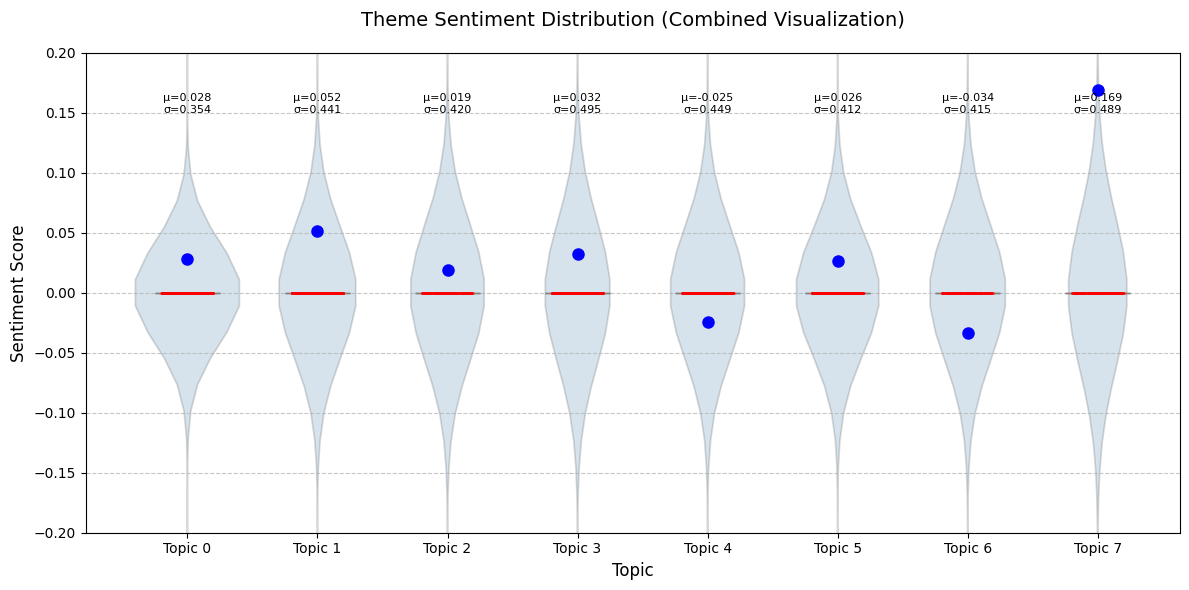

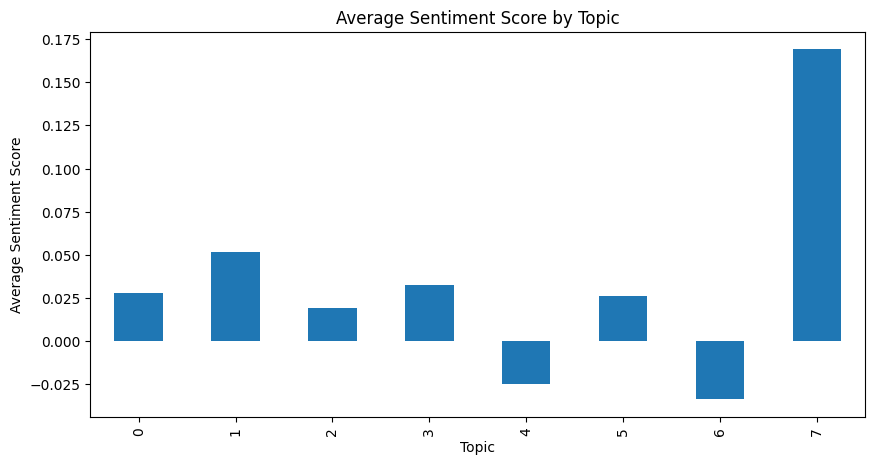

In [3]:
import pandas as pd

df = pd.read_csv("../2_data/tweets_with_topics.csv")

topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)

topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]

print(topic_sentiment_stats)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# visualization
# 1. Box plot (no outliers shown)
ax = sns.boxplot(x='topic', y='sentiment_score', data=df,
                width=0.5,
                showfliers=False,  
                color='lightgrey')

# 2. Adding a jitter scatterplot to a box plot
sns.stripplot(x='topic', y='sentiment_score', 
             data=df.sample(n=5000, random_state=42),  # 采样5000个点
             size=2, alpha=0.3, 
             jitter=0.2,
             color='red')

# 3. add violin plot
sns.violinplot(x='topic', y='sentiment_score', data=df,
               alpha=0.2,  
               inner=None)  # do not show inner boxplot

# Set the display range to focus on the main distribution area
plt.ylim(-0.2, 0.2)

# add mean points
means = df.groupby('topic')['sentiment_score'].mean()
plt.plot(range(len(means)), means, 'o', color='blue', markersize=8, label='Mean')

plt.title('Theme Sentiment Distribution (Combined Visualization)', size=14, pad=20)
plt.xlabel('Topic', size=12)
plt.ylabel('Sentiment Score', size=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding a Theme Tag
plt.xticks(range(8), [f'Topic {i}' for i in range(8)])

# Adding Statistical Information Labeling
for i, mean in enumerate(means):
    std = df[df['topic'] == i]['sentiment_score'].std()
    plt.text(i, 0.15, f'μ={mean:.3f}\nσ={std:.3f}', 
             horizontalalignment='center',
             size=8)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
topic_sentiment_stats['Avg Sentiment'].plot(kind='bar')
plt.title('Average Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

topic_sentiment_stats.to_csv("../2_data/LDAtopic_sentiment_stats.csv")



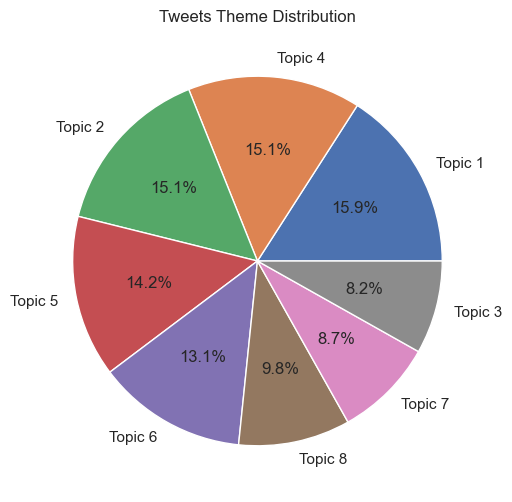

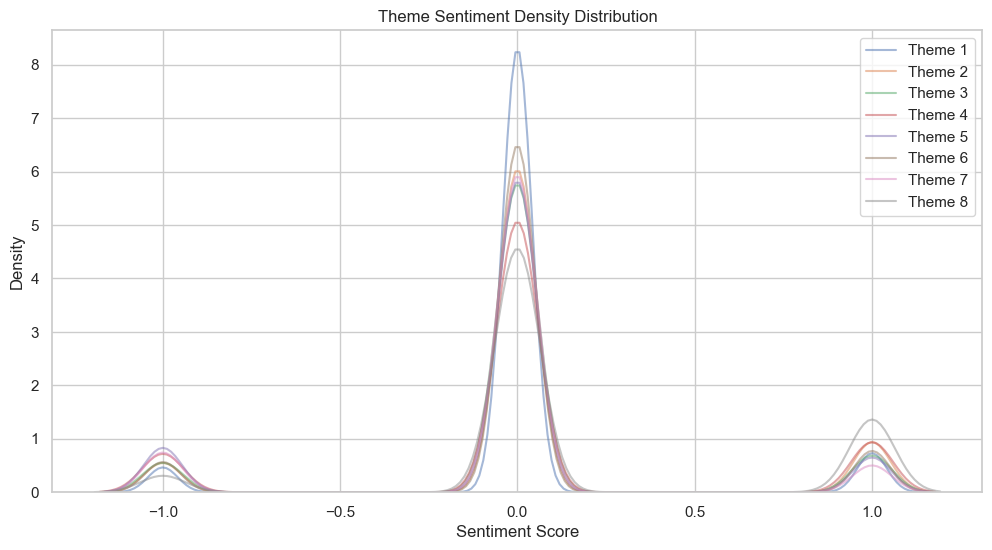

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_palette("husl")



sns.set_theme(style="whitegrid")  

# 1. Thematic Distribution Pie Chart
plt.figure(figsize=(12, 6))
topic_counts = df['topic'].value_counts()
plt.pie(topic_counts, labels=[f'Topic {i+1}' for i in topic_counts.index], autopct='%1.1f%%')
plt.title('Tweets Theme Distribution')
plt.show()

# 2. Theme Sentiment Density Plot
plt.figure(figsize=(12, 6))
n_topics = df['topic'].nunique()
for topic in range(n_topics):
    sns.kdeplot(data=df[df['topic'] == topic]['sentiment_score'], 
                label=f'Theme {topic+1}', alpha=0.5)
plt.title('Theme Sentiment Density Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## 5. Extreme emotion topic analysis

In [5]:
print(df.columns)

Index(['Date', 'Processed_Tweet', 'sentiment_score', 'sentiment_label',
       'category', 'processed_text', 'topic'],
      dtype='object')


In [6]:
# Find the most extreme topic
most_positive_topic = topic_sentiment_stats['Avg Sentiment'].idxmax()
most_negative_topic = topic_sentiment_stats['Avg Sentiment'].idxmin()

print(f"Most positive theme (Theme {most_positive_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_positive_topic, 'Avg Sentiment']:.4f}")
print(f"High positive sentiment ratio: {topic_sentiment_stats.loc[most_positive_topic, 'High positive ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_positive_topic]['Processed_Tweet'].head())

print(f"\nMost negative theme (Theme {most_negative_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_negative_topic, 'Avg Sentiment']:.4f}")
print(f"High negative sentiment ratio: {topic_sentiment_stats.loc[most_negative_topic, 'High negative ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_negative_topic]['Processed_Tweet'].head())

Most positive theme (Theme 8):
Average sentiment score: 0.1690
High positive sentiment ratio: 21.85%

Example tweets from this theme:
7                  amzn sq nvda decemb stock mkt glitch
9     kristit sinc june ipo much better amzn nvda ti...
23    nvda reentri abl afford hous stock market rece...
24    idrawlin im still stick market cap floor nvda ...
28    thank spi dump move anyth possibl market look ...
Name: Processed_Tweet, dtype: object

Most negative theme (Theme 7):
Average sentiment score: -0.0336
High negative sentiment ratio: 10.36%

Example tweets from this theme:
20                nvda larg unusu print bullish bearish
22    nvda everyon scare short bearish let rug pull ...
26    aapl fb nvda googl nflx energi time spend stoc...
33                                   nvda heavi bullish
65    nvda cramer said stop trade go long nvda game ...
Name: Processed_Tweet, dtype: object


Topic 0: Best thresholds => positive: 0.02, negative: -0.09 ; Cumulative Return: 179.29%
Topic 1: Best thresholds => positive: 0.06, negative: -0.10 ; Cumulative Return: 183.59%
Topic 2: Best thresholds => positive: 0.03, negative: -0.10 ; Cumulative Return: 24.00%
Topic 3: Best thresholds => positive: 0.05, negative: -0.10 ; Cumulative Return: 724.57%
Topic 4: Best thresholds => positive: 0.01, negative: -0.04 ; Cumulative Return: 358.88%
Topic 5: Best thresholds => positive: 0.02, negative: -0.04 ; Cumulative Return: 785.27%
Topic 6: Best thresholds => positive: 0.04, negative: -0.10 ; Cumulative Return: -41.22%
Topic 7: Best thresholds => positive: 0.01, negative: -0.10 ; Cumulative Return: 233.54%

Cumulative Returns for Optimized Strategies:


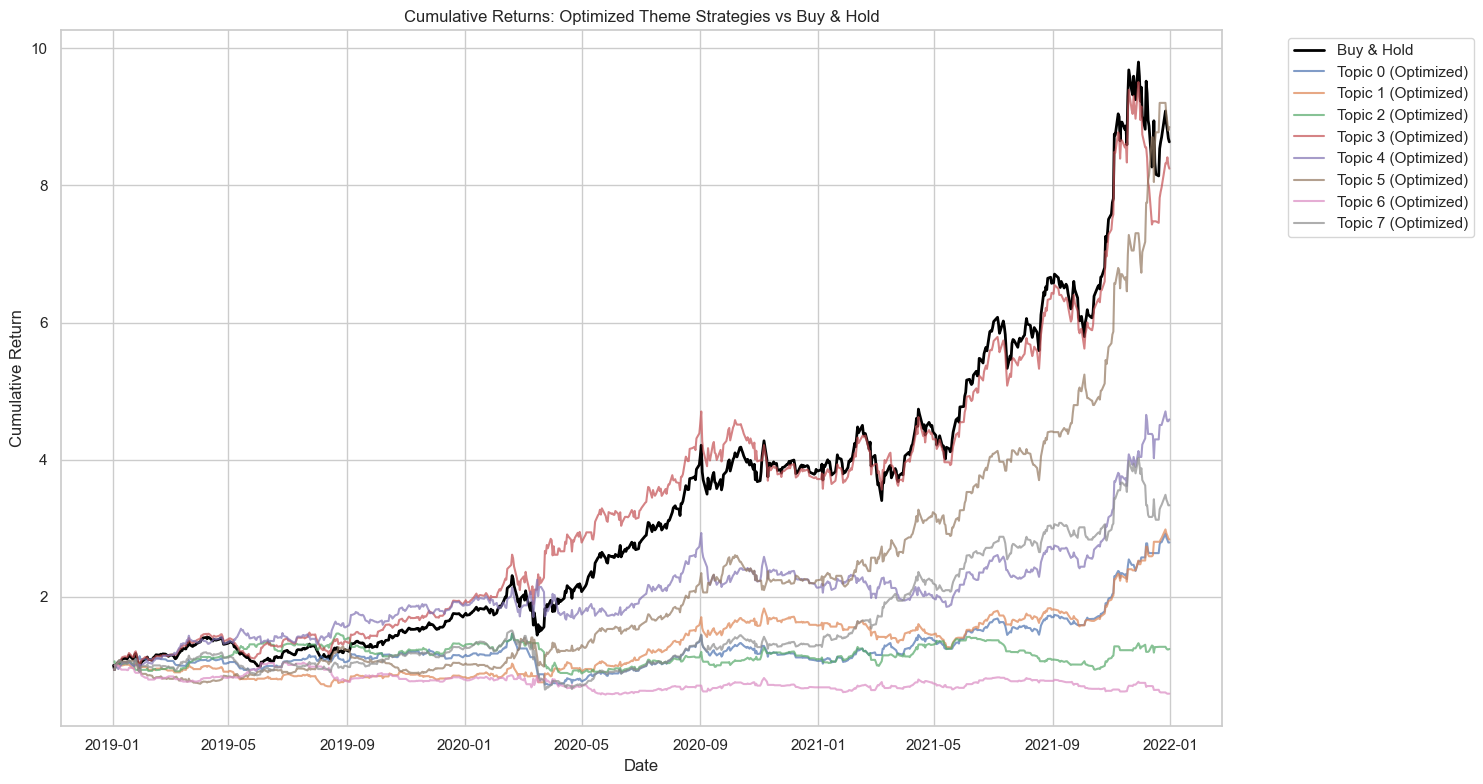


Final Returns by Optimized Thematic Strategy:
Topic 0 (Optimized): 179.29%
Topic 1 (Optimized): 183.59%
Topic 2 (Optimized): 24.00%
Topic 3 (Optimized): 724.57%
Topic 4 (Optimized): 358.88%
Topic 5 (Optimized): 785.27%
Topic 6 (Optimized): -41.22%
Topic 7 (Optimized): 233.54%
Buy & Hold: 763.63%


In [8]:
import pandas as pd
import numpy as np

#read price data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# read daily theme sentiment data
df = pd.read_csv("../2_data/tweets_with_LDAtopics.csv")
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# define the range of thresholds for Grid Search
positive_thresholds = np.arange(0.01, 0.11, 0.01)
negative_thresholds = -np.arange(0.01, 0.11, 0.01)

# store the best thresholds and returns for each topic
best_thresholds_by_topic = {}

# for each topic, perform Grid Search to find the best positive and negative thresholds
for topic in daily_theme_sentiment.columns:
    best_return = -np.inf
    best_thresh = (None, None)
    
    # use grid search to find the best combination of positive and negative thresholds
    for pos_thresh in positive_thresholds:
        for neg_thresh in negative_thresholds:
            # calculate the signal based on the current thresholds
            signal = daily_theme_sentiment[topic].rolling(3, min_periods=1).mean()
            # generate position based on the signal and thresholds
            position = (signal > pos_thresh).astype(int) - (signal < neg_thresh).astype(int)
            
            # align the strategy data with the price data
            strategy_data = pd.DataFrame({'position': position})
            strategy_data = strategy_data.merge(price_df[['nvda_close']], left_index=True, right_index=True, how='inner')
            
            # calculate cumulative returns for the strategy
            returns = price_df['nvda_close'].pct_change().fillna(0)
            # shift the position to avoid lookahead bias
            strategy_returns = strategy_data['position'].shift(1) * returns.loc[strategy_data.index]
            cum_return = (1 + strategy_returns).prod() - 1
            
            # update the best thresholds if the current combination yields a better return
            if cum_return > best_return:
                best_return = cum_return
                best_thresh = (pos_thresh, neg_thresh)
    
    best_thresholds_by_topic[topic] = (best_thresh, best_return)
    print(f"Topic {topic}: Best thresholds => positive: {best_thresh[0]:.2f}, negative: {best_thresh[1]:.2f} ; Cumulative Return: {best_return:.2%}")


# 3. calculate cumulative returns for each strategy and plot them
returns = price_df['nvda_close'].pct_change().fillna(0)

plt.figure(figsize=(15, 8))

# Start by plotting the payoff curve of the “buy and hold” strategy
cum_returns_buy_and_hold = (1 + returns).cumprod()
plt.plot(cum_returns_buy_and_hold.index, cum_returns_buy_and_hold, label='Buy & Hold', color='black', linewidth=2)

# Plot the strategy payoff curve for each theme using the optimal threshold portfolio
print("\nCumulative Returns for Optimized Strategies:")
for topic, (best_thresh, best_return) in best_thresholds_by_topic.items():
    pos_thresh, neg_thresh = best_thresh

    # Re-generate the signal using the optimal threshold
    signal = daily_theme_sentiment[topic].rolling(3, min_periods=1).mean()
    position = (signal > pos_thresh).astype(int) - (signal < neg_thresh).astype(int)

    # data alignment
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )

    # calculate cumulative returns for the strategy
    # make sure to shift the position to avoid lookahead bias
    strategy_returns = strategy_data['position'].shift(1) * returns.loc[strategy_data.index]
    cum_strategy_returns = (1 + strategy_returns).cumprod()

    # plot
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Topic {topic} (Optimized)', alpha=0.7)

plt.title('Cumulative Returns: Optimized Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the final payoff for each optimal strategy
print("\nFinal Returns by Optimized Thematic Strategy:")
for topic, (best_thresh, best_return) in best_thresholds_by_topic.items():

    print(f"Topic {topic} (Optimized): {best_return:.2%}")

print(f"Buy & Hold: {cum_returns_buy_and_hold.iloc[-1]-1:.2%}")

In [9]:
# Print top 50 keywords for topics 1, 3, and 7
topics_to_print = [3,5]  

for topic_idx in topics_to_print:
    top_words = [feature_names[i] for i in lda.components_[topic_idx].argsort()[:-51:-1]]  # Top 50 keywords
    print(f"Top 50 keywords for Topic {topic_idx}:")
    print(', '.join(top_words))
    print()

Top 50 keywords for Topic 3:
tsla, good, great, look, strong, gap, support, start, stay, alway, right, guess, daili, mean, long, resist, mani, thought, action, probabl, revers, number, opportun, bet, cash, pay, free, trend, check, moon, point, flow, entri, till, chanc, area, luck, potenti, news, away, updat, tesla, pre, wall, dont, predict, broke, expect, oversold, job

Top 50 keywords for Topic 5:
earn, rocket, watch, hour, new, hope, bad, news, everi, data, anyon, mention, option, pleas, alert, wtf, power, minut, wallstreetbet, past, tank, fli, jensen, guidanc, lmao, ticker, final, learn, product, base, sector, center, cramer, world, increas, start, place, late, comput, ceo, boom, activ, goog, histor, flag, rank, block, imagin, left, wednesday



In [10]:
import pandas as pd

df = pd.read_csv("../2_data/tweets_with_LDAtopics.csv")
df['Date'] = pd.to_datetime(df['Date'])

# calculate daily sentiment statistics for each topic
topic_stats = df.groupby(['Date', 'topic'])['sentiment_score'].agg(
    avg_sentiment_score='mean',
    tweet_count='count',
    sentiment_std='std'
).reset_index()

# only keep the relevant topics
topics_to_save = [3,5]

for topic in topics_to_save:
    topic_data = topic_stats[topic_stats['topic'] == topic][['Date', 'avg_sentiment_score', 'tweet_count', 'sentiment_std']]
    topic_data.rename(columns={'Date': 'date'}, inplace=True)
    topic_data.to_csv(f"../2_data/topic_{topic}_LDA_sentiment_stats.csv", index=False)
    print(f"Saved topic {topic} data to ../2_data/topic_{topic}_LDA_sentiment_stats.csv")

Saved topic 3 data to ../2_data/topic_3_LDA_sentiment_stats.csv
Saved topic 5 data to ../2_data/topic_5_LDA_sentiment_stats.csv
